In [ ]:
import numpy as np
import pandas as pd
import cv2
import PIL
import easyocr

In [5]:
!pip install easyocr

### Edge Detection

In [13]:
image = cv2.imread('korean/1.jpg')
orig = image.copy()          # 오리지널 이미지는 복사해서 저장 
r = 800.0 / image.shape[0]
dim = (int(image.shape[1] * r), 800)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) # 이미지 리사이즈 

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 그레이 컬러로 변환
gray = cv2.GaussianBlur(gray, (3, 3), 0)        # 블러 효과 주기
edged = cv2.Canny(gray, 75, 200)                # canny를 통해 엣지 검출 

# print ("STEP 1: Edge Detection")
# cv2.imshow("Image", image)
# cv2.imshow("Edged", edged)


# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.waitKey(1)

### Find Contours of Paper

In [21]:
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]   # 컨투어가 그린 면적이 큰 순서대로 

for c in cnts:
    peri = cv2.arcLength(c, True)    # 컨투어가 그리는 길이 반환
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)     # 2%를 오차로 하여 도형을 근사해서 외곽 추출 
    
    if len(approx) == 4:   # 꼭지점이 4개라면 
        screenCnt = approx # 그것이 명함의 외곽
        print(screenCnt)
        print(screenCnt.shape)
        print(screenCnt.reshape(4, 2) / r)
        print(screenCnt.reshape(4, 2).shape)
        break
        
# print ("STEP 2: Find contours of paper")
# cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
# cv2.imshow("Outline", image)                                 # 네모가 그려진 이미지 출력

# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.waitKey(1)

[[[ 69  25]]

 [[ 48 763]]

 [[438 776]]

 [[474  65]]]
(4, 1, 2)
[[ 347.76  126.  ]
 [ 241.92 3845.52]
 [2207.52 3911.04]
 [2388.96  327.6 ]]
(4, 2)


### Apply Perspective Transform
* 4개의 꼭지점으로 반듯한 사각형으로 변환하는 단계 

In [24]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = 'float32')
    
    s = pts.sum(axis = 1)
    print(pts)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    print(diff, "diff")
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [25]:
rect = order_points(screenCnt.reshape(4, 2) / r)
(topLeft, topRight, bottomRight, bottomLeft) = rect

w1 = abs(bottomRight[0] - bottomLeft[0])
w2 = abs(topRight[0] - topLeft[0])
h1 = abs(topRight[1] - bottomRight[1])
h2 = abs(topLeft[1] - bottomLeft[1])
maxWidth = max([w1, w2])
maxHeight = max([h1, h2])

dst = np.float32([[0,0], [maxWidth-1,0], 
                  [maxWidth-1,maxHeight-1], [0,maxHeight-1]])

M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

# show the original and scanned images
print ("STEP 3: Apply perspective transform")
cv2.imshow("Warped", warped)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

[[ 347.76  126.  ]
 [ 241.92 3845.52]
 [2207.52 3911.04]
 [2388.96  327.6 ]]
[[ -221.76]
 [ 3603.6 ]
 [ 1703.52]
 [-2061.36]] diff


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'warpPerspective'
> Overload resolution failed:
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type


### Apply Adaptive Threshold

In [8]:
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY) # grayscale
warped = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_MEAN_C, Cv2.THRESH_BINARY, 21, 10)
                                            # 흑백 이미지로 binarization

print ("STEP 4 : Apply Adaptive Threshold")
cv2.imshow("Original", orig)
cv2.imshow("Scanned", warped)
cv2.imwrite("scannedImage.png", warped)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

NameError: name 'warped' is not defined

In [3]:
img_cv = cv2.imread('./korean/3.png')

# cv2.imshow("Business Card", img_cv)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### lang='kor' 이름
### lang='eng' 이메일, 전화번호 

In [ ]:
import easyocr
reader = easyocr.Reader(['ko', 'en'])

In [3]:
result = reader.readtext('./korean/4.jpg', detail = 0) # gpu=False
print(result)

RuntimeError: CUDA out of memory. Tried to allocate 1.17 GiB (GPU 0; 1.83 GiB total capacity; 153.49 MiB already allocated; 777.06 MiB free; 164.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=48b8dc956f767994de884b9f5c9b22c61fc30df7815f5517887922d695118de8
  Stored in directory: /home/cherimlee/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built GPUtil


In [11]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()     

| ID | GPU | MEM |
------------------
|  0 |  0% | 59% |


In [9]:
import torch
torch.cuda.empty_cache()

In [15]:
!pip install numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 11.1 MB/s eta 0:00:00m eta 0:00:010:01:01


In [16]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [17]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  3% |


In [4]:

import torch
import gc

gc.collect()

torch.cuda.empty_cache()


In [9]:
inputs = {a.cuda(), b.cuda(), c.cuda()}
outputs = model(**inputs)
del inputs
torch.cuda.empty_cache()
cls, prob = model(text)
#prob = tensor(1, device=cuda:0, grad_fn=<MaxBackWard1>)
percent.append(prob.item())
del prob
torch.cuda.empty_cache()

NameError: name 'a' is not defined

In [10]:
features = []
for x, y in train_loader:
    x = torch.tensor(x, device=device, dtype=torch.float32)
    z = model(x)
    features.append(z.tolist())

NameError: name 'train_loader' is not defined

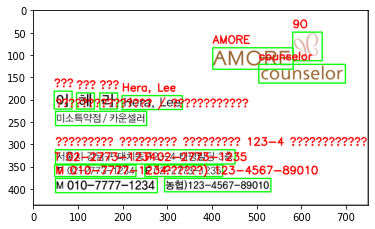

In [7]:
import cv2
import easyocr
import matplotlib.pyplot as plt
image = cv2.imread('./korean/3.png')
reader = easyocr.Reader(['ko', 'en'])
result = reader.readtext('./korean/3.png')
for (bbox, text, prob) in result :
  (tl, tr, br, bl) = bbox
  tl = (int(tl[0]), int(tl[1]))
  tr = (int(tr[0]), int(tr[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))
  cv2.rectangle(image, tl, br, (0, 255, 0), 2)
  cv2.putText(image,text, (tl[0], tl[1] - 10),
  cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
plt.rcParams['figure.figsize'] = (16,16)
plt.imshow(image)

In [ ]:
import easyocr
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

reader = easyocr.Reader(['ko','en']) 
result = reader.readtext('./demo_image/3.png')
img    = cv2.imread('./demo_image/3.png')
img = Image.fromarray(img)
font = ImageFont.truetype("HMKMRHD.TTF",20)
draw = ImageDraw.Draw(img)

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")

for i in result :
    print(i[1:3])
    x = i[0][0][0]
    y = i[0][0][1]
    w = i[0][1][0] - i[0][0][0]
    h = i[0][2][1] - i[0][1][1]
    
    color_idx = random.randint(0,255)
    color = [int(c) for c in COLORS[color_idx]]
    
    draw.rectangle(((x, y), (x+w, y+h)), outline=tuple(color), width=2)
    draw.text((int((x + x + w) / 2) , y-10), str(i[1]), font=font, fill=tuple(color),)

plt.imshow(img)
plt.show()

In [1]:
import easyocr
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

reader = easyocr.Reader(['ko', 'en'], gpu = False)
result = reader.readtext('./korean/3.png')
img    = cv2.imread('./korean/3.png')
img = Image.fromarray(img)
font = ImageFont.load_default()
draw = ImageDraw.Draw(img)
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")
for i in result :
    x = i[0][0][0] 
    y = i[0][0][1] 
    w = i[0][1][0] - i[0][0][0] 
    h = i[0][2][1] - i[0][1][1]

    color_idx = random.randint(0,255) 
    color = [int(c) for c in COLORS[color_idx]]

    draw.rectangle(((x, y), (x+w, y+h)), outline=tuple(color), width=2)
    draw.text((int((x + x + w) / 2) , y-2),str(i[1]), font=font, fill=tuple(color),)

plt.figure(figsize=(50,50))
plt.imshow(img)
plt.show()

Using CPU. Note: This module is much faster with a GPU.


UnicodeEncodeError: 'latin-1' codec can't encode character '\uc774' in position 0: ordinal not in range(256)

In [8]:
import easyocr
import numpy as np
import random
import cv2
reader = easyocr.Reader(['ko','en']) # need to run only once to load model into memory
result = reader.readtext('./korean/3.png')
img    = cv2.imread('./korean/3.png')

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")


for i in result :
    x = i[0][0][0]
    y = i[0][0][1]
    w = i[0][1][0] - i[0][0][0]
    h = i[0][2][1] - i[0][1][1]
    
    color_idx = random.randint(0,255)
    color = [int(c) for c in COLORS[color_idx]]
    
    cv2.putText(img, str(i[1]), (int((x + x + w) / 2) , y-2), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    img = cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)

cv2.imshow("test",img)
cv2.waitKey(0)

IndexError: index 255 is out of bounds for axis 0 with size 255

In [9]:
import easyocr
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

reader = easyocr.Reader(['ko','en']) # need to run only once to load model into memory
result = reader.readtext('./korean/3.png')

img    = cv2.imread('./korean/3.png')

img = Image.fromarray(img)
font = ImageFont.load_default()
draw = ImageDraw.Draw(img)

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")


for i in result :
    x = i[0][0][0]
    y = i[0][0][1]
    w = i[0][1][0] - i[0][0][0]
    h = i[0][2][1] - i[0][1][1]
    
    color_idx = random.randint(0,255)
    color = [int(c) for c in COLORS[color_idx]]
    
#    cv2.putText(img, str(i[1]), (int((x + x + w) / 2) , y-2), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
#    img = cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    draw.rectangle(((x, y), (x+w, y+h)), outline=tuple(color), width=2)
    draw.text((int((x + x + w) / 2) , y-2),str(i[1]), font=font, fill=tuple(color),)

plt.imshow(img)
plt.show()
# cv2.imshow("test",img)
# cv2.waitKey(0)


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


UnicodeEncodeError: 'latin-1' codec can't encode character '\uc774' in position 0: ordinal not in range(256)

In [7]:
kor_cv = pytesseract.image_to_string(image, lang='kor')

In [8]:
eng_cv = pytesseract.image_to_string(image, lang='eng')

In [15]:
koreng_cv = pytesseract.image_to_string(img_cv, lang='eng+kor')

In [9]:
print(kor_cv)

트. 11007@비0100.61   본 사 서울시 강남구 자곡로7길 4, 2층 207호
번. 010:4843'4144 연구소 서울시 노원구 초안산로 12,인덕대학교 제1공학관 504호

%

1. 070 88576265
『. 0303:3441:0051 지 점 대구광역시 북구 호암로 51, 대구창조경제혁신센터 4충

 



In [10]:
print(eng_cv)

E. hitliy@bitflow.ai = AE ASA Bet HB B74 4, 26 2078
M. 010-4843-4144 oi yea|iegla ote 12, OICHRIA ABBR S04

=

T. 070-8857-6265
F. 0303-3441-0051 Al Y APRA) $7 Sots 51, AA AMOAIME! 4B

 



In [16]:
print(koreng_cv)

 

 

AMORE
counselor

O| al 2b Hera, Lee
미 소 특 약 점 / 카운셀러

서울시 강남구 대치동 123-4 태 평 빌딩 3 층
7 ㅜ 02-2773-1234 『02-2773-1235
M 010-7777-1234 S#)123-4567-89010

 

 



In [ ]:
text_pl = pytesseract.image_to_string(img_pl, lang='kor')

## Spacy

In [7]:
import numpy as np
import pandas as pd
import cv2
import pytesseract
from glob import glob
import spacy
import re
import string

In [8]:
def cleanText(txt):
    whitespace = string.whitespace
    punctuation = "!#$%&\'()*+:;<=>?[\\]^`{|}~"
    tableWhitespace = str.maketrans('','',whitespace)
    tablePunctuation = str.maketrans('','',punctuation)
    text = str(txt)
    text = text.lower()
    removewhitespace = text.translate(tableWhitespace)
    removepunctuation = removewhitespace.translate(tablePunctuation)
    
    return str(removepunctuation)

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
### Load NER model
model_ner = spacy.load('./output/model-best/')

In [24]:
nlp = spacy.load("ko_core_news_sm")

In [27]:
import spacy

nlp = spacy.load('ko_core_news_sm')
text = 'Yuh-jung Youn won the Oscar for best supporting actress for her performance in "Minari" on Sunday and made history by becoming the first Korean actor to win an Academy Award.'
doc = nlp(text)
tokenized = list(doc)
print(tokenized)

[Yuh, -, jung, Youn, won, the, Oscar, for, best, supporting, actress, for, her, performance, in, ", Minari, ", on, Sunday, and, made, history, by, becoming, the, first, Korean, actor, to, win, an, Academy, Award, .]


In [22]:
# Load Image
image = cv2.imread('./korean/3.png')

# cv2.imshow('businesscard',image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# extract data using Pytesseract 
tessData = pytesseract.image_to_data(image, lang='kor')
# convert into dataframe
tessList = list(map(lambda x:x.split('\t'), tessData.split('\n')))
df = pd.DataFrame(tessList[1:],columns=tessList[0])
df.dropna(inplace=True) # drop missing values
df['text'] = df['text'].apply(cleanText)

# convet data into content
df_clean = df.query('text != "" ')
content = " ".join([w for w in df_clean['text']])
print(content)
# get prediction from NER model
doc = model_ner(content)

0042 0041715610 이 헤 라 11613, 66 미 소 특 약 점 / 카운셀러 서울시 강남구 대치동 123-4 태 평 빌딩 3 층 7 ㅜ 02-2773-1234 『02-2773-1235 1010-7777-1234 농 협 123-4567-89010


In [19]:
# Load Image
image = cv2.imread('./korean/3.png')

# cv2.imshow('businesscard',image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# extract data using Pytesseract 
tessData = pytesseract.image_to_data(image)
# convert into dataframe
tessList = list(map(lambda x:x.split('\t'), tessData.split('\n')))
df = pd.DataFrame(tessList[1:],columns=tessList[0])
df.dropna(inplace=True) # drop missing values
df['text'] = df['text'].apply(cleanText)

# convet data into content
df_clean = df.query('text != "" ')
content = " ".join([w for w in df_clean['text']])
print(content)
# get prediction from NER model
doc = model_ner(content)

amore counselor o al 2b hera, lee diasore / 72mal mba vete hals 123-4 hbys 3s t 02-2773-1234 f 02-2773-1235 m 010-7777-1234 s123-4567-89010


In [10]:
from spacy import displacy

In [25]:
displacy.serve(doc,style='ent')

TypeError: 'Korean' object is not iterable